<a href="https://colab.research.google.com/github/PDBeurope/pdbe-api-training/blob/gen_merge_jan24/yearly-statistics/PDBe_yearly_release_stats_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://www.ebi.ac.uk/pdbe/sites/default/files/2019-04/PDBe-letterhead-charcoal-RGB_2013.png"
 height="100" align="right">

# PDBe statistics for 2024

The Protein Data Bank in Europe (PDBe) is a leading resource for the collection, organisation, and dissemination of macromolecular structures. This notebook explores the experimentally-determined macromolecular structures made public (released) in 2024.

Data was gathered using the PDBe's 'Advanced search' service / APIs (also called: [Solr-based query]([https://www.ebi.ac.uk/pdbe/api/doc/search.html) system).

### How to use Google Colab
1. To run a code cell, click on the cell to select it. You will notice a play button (▶️) on the left side of the cell. Click on the play button or press Shift+Enter to run the code in the selected cell.
2. The code will start executing, and you will see the output, if any, displayed below the code cell.
3. Move to the next code cell and repeat steps 2 and 3 until you have executed all the desired code cells in sequence.
4. The currently running step is indicated by a circle with a stop sign next to it. If you need to stop or interrupt the execution of a code cell, you can click on the stop button (■) located next to the play button.
5. Remember to run the code cells in the correct order, as their execution might depend on variables or functions defined in previous cells. You can modify the code in a code cell and re-run it to see updated results.

Notebook prepared by Paulyna Magaña, Genevieve Evans and Sudakshina Ganguly.


In [1]:
#@markdown  Run this code to import and set global variables
!pip install solrq
#pip install py3Dmol
#pip install rdkit


import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from solrq import Q  # For query formatting
search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"



# Set seaborn style
sns.set(style="whitegrid")

# Define the PDBe API URL
search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"

def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}

def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])

def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results

def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results

def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")


# Here we are showing you some data from 2024, the code will display a table showing the first 5 entries extracted
search_terms = Q(status="REL", release_year=2024)
# Search terms and filters
filter_terms = ['pdb_id', 'title', 'organism_scientific_name',
                'experimental_method',
                'resolution', 'em_resolution',
                'journal', 'refinement_software',
                'synchrotron_site', 'em_electron_detection',
                'cath_code',
                'assembly_composition',
                'q_all_molecule_names',
                'q_nmr_software_classification',
                'q_nmr_software_name',
                'processing_site', 'entity_weight', 'interacting_ligands']

# group search
results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

# display the first 5 results as a table
df_results = pandas_dataset(results)
display_table(df_results, top_n=5)


All ready, move to next code


,q_all_molecule_names,assembly_composition,em_electron_detection,em_resolution,entity_weight,experimental_method,journal,organism_scientific_name,pdb_id,processing_site,resolution,title,refinement_software,synchrotron_site,q_nmr_software_classification,q_nmr_software_name,interacting_ligands
0,TrwE protein,protein/protein complex,GATAN K3 (6k x 4k),3.05,42443.785,Electron Microscopy,EMBO J,Escherichia coli,8rt8,PDBE,3.05,Conformation-C of the full-length outer membra...,NaN,NaN,NaN,NaN,NaN
1,"E2,Peplomer protein,S glycoprotein,Spike glyco...",protein/protein complex,NaN,NaN,22361.924,X-ray diffraction,J Virol,Severe acute respiratory syndrome coronavirus 2,8rrn,PDBE,3.11,Crystal structure of the SARS-CoV-2 S RBD in c...,PHENIX,SLS,NaN,NaN,NaN
2,"APLP-2,APPH,Amyloid beta (A4) precursor-like p...",protein structure,NaN,NaN,3211.024,Solution NMR,ACS Chem Neurosci,Homo sapiens,8rq6,PDBE,NaN,Solution NMR structure of Amyloid beta precurs...,NaN,NaN,"chemical shift assignment,peak picking,refinem...","ARIA,CcpNmr Analysis",NaN
3,"50S ribosomal protein L32,Large ribosomal subu...",RNA/protein complex,GATAN K3 BIOQUANTUM (6k x 4k),2.44,6332.249,Electron Microscopy,Nat Commun,Escherichia coli,8rpz,PDBE,2.44,Escherichia coli 50S subunit in complex with t...,NaN,NaN,NaN,NaN,NaN
4,5S ribosomal RNA,RNA/protein complex,GATAN K2 QUANTUM (4k x 4k),3.9,38951.105,Electron Microscopy,To be published,Saccharomyces cerevisiae S288C,8yld,PDBC,3.90,State 4a (S4a) of yeast 80S ribosome bound to ...,NaN,NaN,NaN,NaN,NaN


In [2]:
# finding out the total number of entries released in 2024

number_of_2024_entries = df_results.index.size

print(number_of_2024_entries, "entries were released in 2024.")

15319 entries were released in 2024.


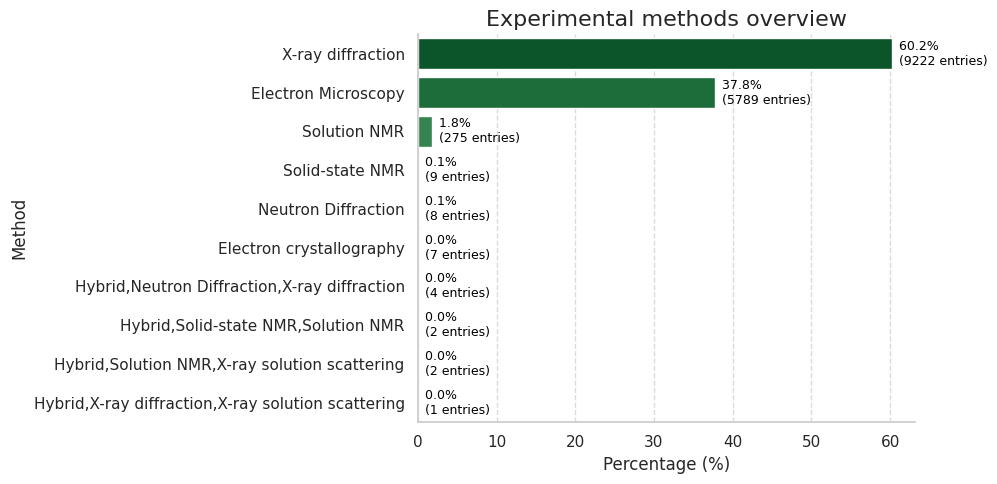

In [3]:
#@title Experimental methods overview

#@markdown This plot will show the experimental methods used for PDB entries released in 2024.

# Assuming 'results' is a DataFrame and 'pandas_count' is a function that groups and counts data

# Make a pandas series object with one column (called 'pdb_id' to be renamed to 'no_of_entries')
counts = pandas_count(results, column_to_group_by='experimental_method')
counts.rename('no_of_entries', inplace=True)

# Make a pandas series object with one column (renamed to 'percentage')
counts_by_percent = (counts / counts.sum()) * 100
counts_by_percent.rename('percentage', inplace=True)

# Limit to top 10 entries
counts = counts.head(10)
counts_by_percentage = counts_by_percent.head(10)

# Merge both series into a DataFrame
df_methods = pd.merge(counts, counts_by_percent, right_index=True, left_index=True)

# Create a figure with a specified size
plt.figure(figsize=(10, 5))

# Create a bar plot with seaborn
# x: values of df_methods['percentage']
# y: index of df_methods
# hue: index of df_methods (for color coding)
# palette: color palette for the bars
ax = sns.barplot(x=df_methods['percentage'].to_numpy(), y=df_methods.index, hue=df_methods.index, palette='Greens_r')

# Set the title of the plot
plt.title("Experimental methods overview", fontsize=16)

# Set the x-axis label
plt.xlabel('Percentage (%)', fontsize=12)

# Set the y-axis label
plt.ylabel('Method', fontsize=12)

# Annotate each bar with its percentage value and number of entries
for value in range(0, 10):
    entries = df_methods['no_of_entries'].to_numpy()[value]
    percent_value = df_methods['percentage'].round(1).to_numpy()[value]
    # Annotate the bar with the percentage value and number of entries
    ax.annotate(f'{percent_value}% \n({entries} entries)', (df_methods['percentage'].to_numpy()[value], df_methods.index[value]),
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0),
                textcoords='offset points')

# Add a grid to the x-axis with dashed lines and some transparency
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove the top and right spines from the plot for a cleaner look
sns.despine()

# Adjust the layout to make sure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [4]:
#@markdown Here we can see the data as a table
pandas_count(results, "experimental_method")

,pdb_id
experimental_method,
X-ray diffraction,9222
Electron Microscopy,5789
Solution NMR,275
Solid-state NMR,9
Neutron Diffraction,8
Electron crystallography,7
"Hybrid,Neutron Diffraction,X-ray diffraction",4
"Hybrid,Solid-state NMR,Solution NMR",2
"Hybrid,Solution NMR,X-ray solution scattering",2


X-ray diffraction accounts for nearly 60% of the total, with ~9K entries. Electron Microscopy takes second place, representing about 38%, with ~6K entries.  Other techniques, such as Solution NMR, Solid-state NMR, and Neutron Diffraction, are employed far less frequently.

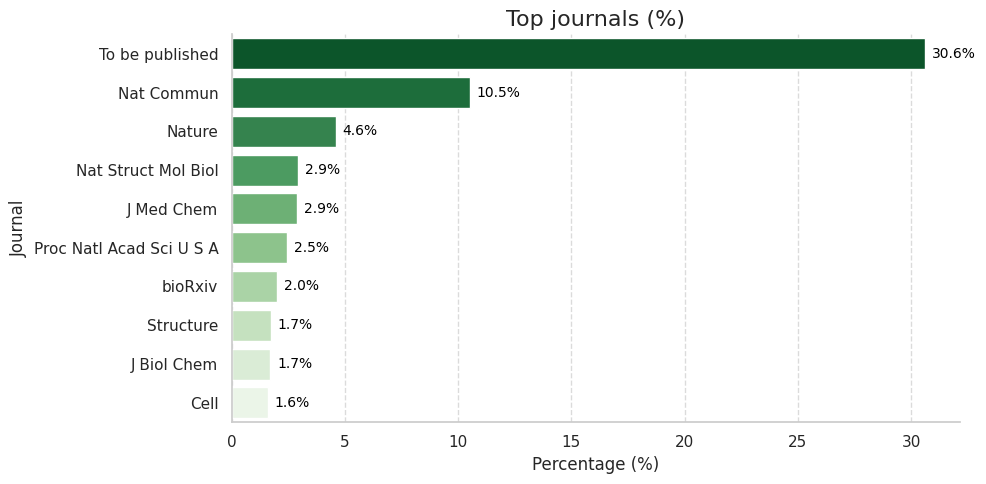

In [5]:
#@title Journals published

#@markdown This plot will show the journals linked to PDB entries released in 2024.
counts = pandas_count(results, column_to_group_by='journal')

show_percentage = True
if show_percentage:
    counts = (counts / counts.sum()) * 100

#limit to top N entries
counts = counts.head(10)

# plotting
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=counts.values, y=counts.index, hue=counts.index, palette='Greens_r')
plt.xlabel('Percentage (%)' if show_percentage else 'Count', fontsize=12)
plt.title("Top journals (%)", fontsize=16)
plt.ylabel('Journal', fontsize=12)

for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.1f}%', (width, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black', xytext=(5, 0),
                textcoords='offset points')
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine()

plt.tight_layout()
plt.show()



In [6]:
#@markdown Here we can see the data for the journals as a table
pandas_count(results, "journal")

,pdb_id
journal,
To be published,4691
Nat Commun,1610
Nature,704
Nat Struct Mol Biol,451
J Med Chem,446
...,...
JUSTC,1
Jacs Au,1
Metallomics,1


The Protein Data Bank in Europe (PDBe) not only archives structural data but also links this data to relevant publications. This analysis of journal representation in the PDBe for 2024 shows that a significant portion of deposited structures (30.3%) are still 'to be published' (currently unpublished or publication unindicated). Among the established journals, Nature Communications stands out with 10.6%, followed by Nature at 4.6%.

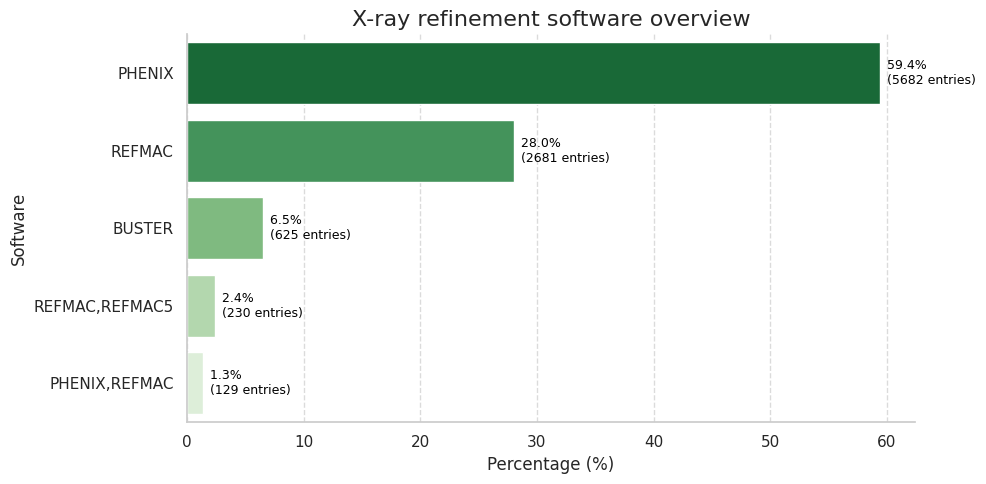

In [7]:
#@title X-ray refinement software

#@markdown This plot will show the most used refinement software for entries released in 2024.

# Assuming 'results' is a DataFrame and 'pandas_count' is a function that groups and counts data

# Make a pandas series object with one column (called 'pdb_id' to be renamed to 'no_of_entries')
counts = pandas_count(results, column_to_group_by='refinement_software')
counts.rename('no_of_entries', inplace=True)

# Make a pandas series object with one column (renamed to 'percentage')
counts_by_percent = (counts / counts.sum()) * 100
counts_by_percent.rename('percentage', inplace=True)

# Limit to top 10 entries
counts = counts.head(5)
counts_by_percentage = counts_by_percent.head(5)

# Merge both series into a DataFrame
df_software = pd.merge(counts, counts_by_percent, right_index=True, left_index=True)

# Create a figure with a specified size
plt.figure(figsize=(10, 5))

# Create a bar plot with seaborn
# x: values of df_software['percentage']
# y: index of df_software
# hue: index of df_software (for color coding)
# palette: color palette for the bars
ax = sns.barplot(x=df_software['percentage'].to_numpy(), y=df_software.index, hue=df_software.index, palette='Greens_r')

# Set the title of the plot
plt.title("X-ray refinement software overview", fontsize=16)

# Set the x-axis label
plt.xlabel('Percentage (%)', fontsize=12)

# Set the y-axis label
plt.ylabel('Software', fontsize=12)

# Annotate each bar with its percentage value and number of entries
for value in range(0, 5):
    entries = df_software['no_of_entries'].to_numpy()[value]
    percent_value = df_software['percentage'].round(1).to_numpy()[value]
    # Annotate the bar with the percentage value and number of entries
    ax.annotate(f'{percent_value}% \n({entries} entries)', (df_software['percentage'].to_numpy()[value], df_software.index[value]),
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0),
                textcoords='offset points')

# Add a grid to the x-axis with dashed lines and some transparency
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove the top and right spines from the plot for a cleaner look
sns.despine()

# Adjust the layout to make sure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [8]:
#@markdown Display the data as a table
refinement_software_counts = pandas_count(results, "refinement_software") # Assign the result of the function to a variable
display(refinement_software_counts)

# Calculate the sum of values in the Series
#sum_values = refinement_software_counts.sum() # Call sum() on the Series
#print(f"The sum of values in the 'refinement_software' column is {sum_values}.")

,pdb_id
refinement_software,
PHENIX,5682
REFMAC,2681
BUSTER,625
"REFMAC,REFMAC5",230
"PHENIX,REFMAC",129
"PHENIX,phenix.real_space_refine",86
"BUSTER,REFMAC5",48
"BUSTER,PHENIX",18
"PDB-REDO,PHENIX",10


This chart indicates the refinement software popularity for structures determined using X-ray crystallograpy. PHENIX being utilized for 59.4% of X-ray crystallography structures. REFMAC comes in second place with 28.0% of the structures. BUSTER holds the third spot, refining 6.5% of the structures.

While they are smaller percentages, it's cool to see that tools like CNS, SHELX, SHELXL, MAIN, PDB-REDO, ISOLDE & PRIME-X are also being used to refine structures.

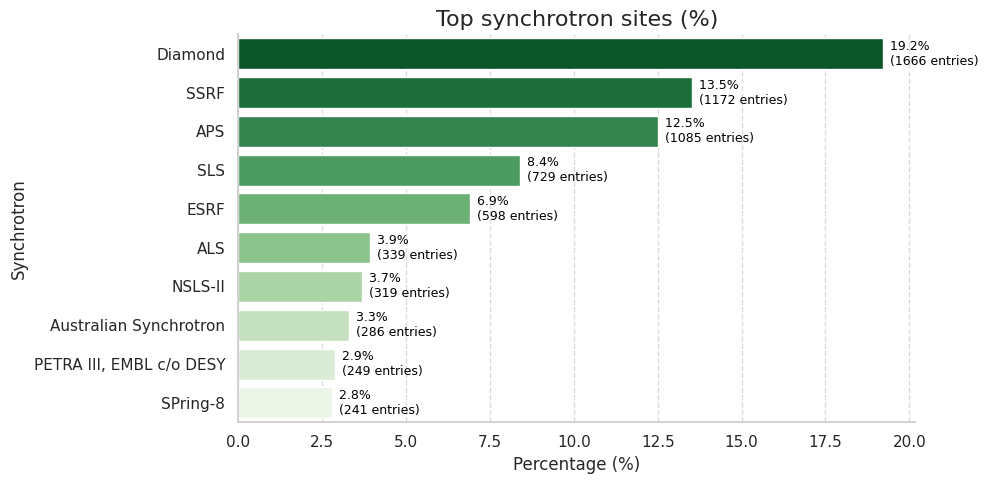

In [9]:
#@title Top synchrotron sites in 2024

#@markdown This plot will show the synchrotrons utilized for X-ray diffraction data collection for entries released in 2024.

# Assuming 'results' is a DataFrame and 'pandas_count' is a function that groups and counts data

# Make a pandas series object with one column (called 'pdb_id' to be renamed to 'no_of_entries')
counts = pandas_count(results, column_to_group_by='synchrotron_site')
counts.rename('no_of_entries', inplace=True)

# Make a pandas series object with one column (renamed to 'percentage')
counts_by_percent = (counts / counts.sum()) * 100
counts_by_percent.rename('percentage', inplace=True)

# Limit to top 10 entries
counts = counts.head(10)
counts_by_percentage = counts_by_percent.head(10)

# Merge both series into a DataFrame
df_sites = pd.merge(counts, counts_by_percent, right_index=True, left_index=True)

# Create a figure with a specified size
plt.figure(figsize=(10, 5))

# Create a bar plot with seaborn
# x: values of df_sites['percentage']
# y: index of df_sites
# hue: index of df_sites (for color coding)
# palette: color palette for the bars
ax = sns.barplot(x=df_sites['percentage'].to_numpy(), y=df_sites.index, hue=df_sites.index, palette='Greens_r')

# Set the title of the plot
plt.title("Top synchrotron sites (%)", fontsize=16)

# Set the x-axis label
plt.xlabel('Percentage (%)', fontsize=12)

# Set the y-axis label
plt.ylabel('Synchrotron', fontsize=12)

# Annotate each bar with its percentage value and number of entries
for value in range(0, 10):
    entries = df_sites['no_of_entries'].to_numpy()[value]
    percent_value = df_sites['percentage'].round(1).to_numpy()[value]
    # Annotate the bar with the percentage value and number of entries
    ax.annotate(f'{percent_value}% \n({entries} entries)', (df_sites['percentage'].to_numpy()[value], df_sites.index[value]),
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0),
                textcoords='offset points')

# Add a grid to the x-axis with dashed lines and some transparency
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove the top and right spines from the plot for a cleaner look
sns.despine()

# Adjust the layout to make sure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [10]:
#@markdown Display the data as a table
pandas_count(results, column_to_group_by='synchrotron_site')

,pdb_id
synchrotron_site,
Diamond,1666
SSRF,1172
APS,1085
SLS,729
ESRF,598
ALS,339
NSLS-II,319
Australian Synchrotron,286
"PETRA III, EMBL c/o DESY",249


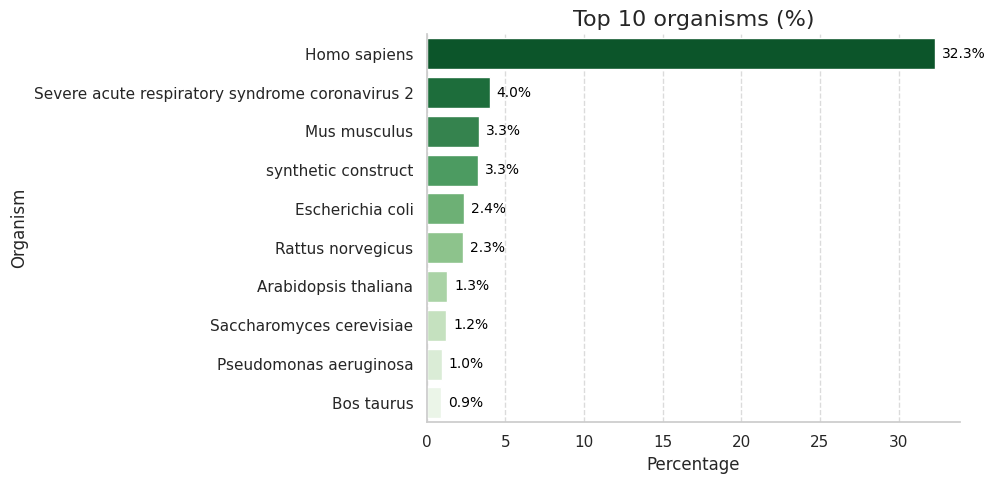

In [11]:
#@title Organisms with more entries in 2024
#@markdown This plot will show the organisms with more structures deposited in the 2024
counts = pandas_count(results, column_to_group_by='organism_scientific_name')

show_percentage = True
if show_percentage:
    counts = (counts / counts.sum()) * 100

#limit to top N entries
counts = counts.head(10)

# plotting
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=counts.values, y=counts.index, hue=counts.index, palette='Greens_r')
plt.xlabel('Percentage' if show_percentage else 'Count', fontsize=12)
plt.title("Top 10 organisms (%)", fontsize=16)
plt.ylabel('Organism', fontsize=12)

for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.1f}%', (width, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black', xytext=(5, 0),
                textcoords='offset points')

plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine()

plt.tight_layout()
plt.show()


Analysis of PDB depositions in 2024 reveals a striking preference for structures related to humans, comprising 32.5% of the total. Synthetic constructs and SARS-CoV-2 follow, each accounting for 4.1%. Model organisms such as *Mus musculus* and *Escherichia coli* represent a smaller but still significant portion. This trend likely reflects the ongoing focus on human health and disease, as well as the continued relevance of synthetic biology and coronavirus research.

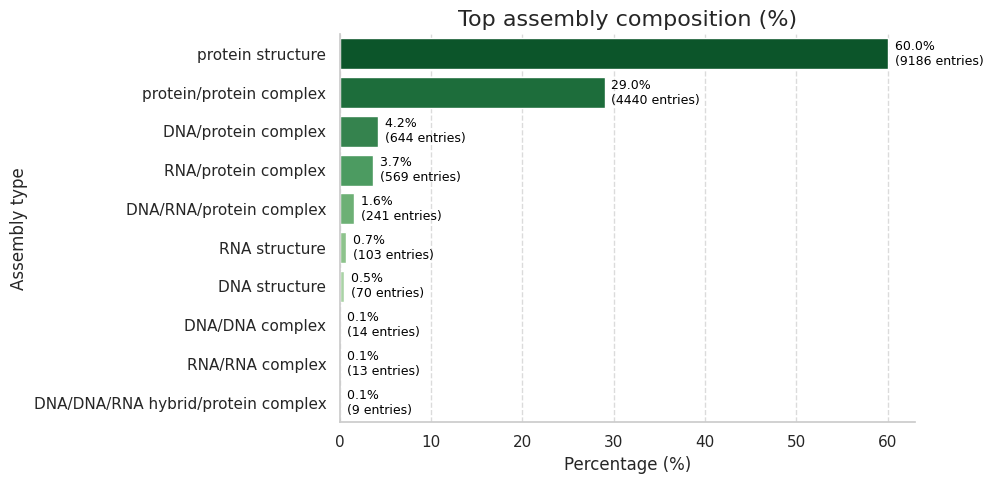

In [12]:
#@title Assembly composition

#@markdown This plot will show the types of assemblies for entries released in 2024.

# Assuming 'results' is a DataFrame and 'pandas_count' is a function that groups and counts data

# Make a pandas series object with one column (called 'pdb_id' to be renamed to 'no_of_entries')
counts = pandas_count(results, column_to_group_by='assembly_composition')
counts.rename('no_of_entries', inplace=True)

# Make a pandas series object with one column (renamed to 'percentage')
counts_by_percent = (counts / counts.sum()) * 100
counts_by_percent.rename('percentage', inplace=True)

# Limit to top 10 entries
counts = counts.head(10)
counts_by_percentage = counts_by_percent.head(10)

# Merge both series into a DataFrame
df_assemblies = pd.merge(counts, counts_by_percent, right_index=True, left_index=True)

# Create a figure with a specified size
plt.figure(figsize=(10, 5))

# Create a bar plot with seaborn
# x: values of df_assemblies['percentage']
# y: index of df_assemblies
# hue: index of df_assemblies (for color coding)
# palette: color palette for the bars
ax = sns.barplot(x=df_assemblies['percentage'].to_numpy(), y=df_assemblies.index, hue=df_assemblies.index, palette='Greens_r')

# Set the title of the plot
plt.title("Top assembly composition (%)", fontsize=16)

# Set the x-axis label
plt.xlabel('Percentage (%)', fontsize=12)

# Set the y-axis label
plt.ylabel('Assembly type', fontsize=12)

# Annotate each bar with its percentage value and number of entries
for value in range(0, 10):
    entries = df_assemblies['no_of_entries'].to_numpy()[value]
    percent_value = df_assemblies['percentage'].round(1).to_numpy()[value]
    # Annotate the bar with the percentage value and number of entries
    ax.annotate(f'{percent_value}% \n({entries} entries)', (df_assemblies['percentage'].to_numpy()[value], df_assemblies.index[value]),
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0),
                textcoords='offset points')

# Add a grid to the x-axis with dashed lines and some transparency
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove the top and right spines from the plot for a cleaner look
sns.despine()

# Adjust the layout to make sure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()

The majority of PDB structures continue to be monomers or homomeric protein complexes, with ~9K structures in 2024 identified as being 'protein structure'. There were over 4,000 protein-protein complexes (non-monomers), with two or more protein chains that have diffferent protein sequence. In contrast, the proteins in complex with RNA and in complex with DNA corresponding to a roughly equal amount at ~600 each.

This suggests that while protein-protein interactions are more studied, there's still a lot to learn about how proteins interact with nucleic acids.

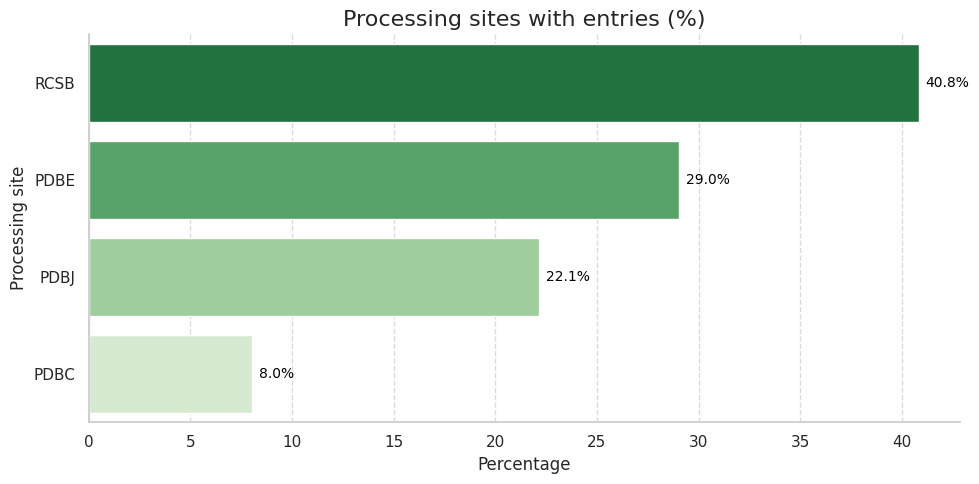

In [13]:
#@title Processing site in 2024

#@markdown This will show the perecentage of entries processed by site in 2024
counts = pandas_count(results, column_to_group_by='processing_site')

show_percentage = True
if show_percentage:
    counts = (counts / counts.sum()) * 100

#limit to top N entries
counts = counts.head(10)

# plotting
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=counts.values, y=counts.index, hue=counts.index, palette='Greens_r')
plt.xlabel('Percentage' if show_percentage else 'Count', fontsize=12)
plt.title("Processing sites with entries (%)", fontsize=16)
plt.ylabel('Processing site', fontsize=12)

for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.1f}%', (width, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black', xytext=(5, 0),
                textcoords='offset points')
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine()

plt.tight_layout()
plt.show()

## Ligands

In structural biology, ligands can be broadly categorized into two groups: those that are integral to the biological system being studied (biological ligands) and those introduced as part of the experimental process (experimental ligands or additives).

We've implemented a filtering step to exclude common experimental ligands often used in crystallization and cryo-electron microscopy (cryo-EM). These additives, while essential for structure determination, can obscure the analysis of true biological interactions.

The following is a list of the ligands that were excluded from the analysis, along with a brief explanation of their typical role in structural studies:

*  GOL (Glycerol): A common cryoprotectant used to prevent ice formation during cryo-electron microscopy and X-ray crystallography
*  PEG (Polyethylene glycol) A polymer used as a precipitant in crystallization experiments
*  CL (Chloride ion) Often present as a counter-ion in buffers or crystallization solutions. Can also be a biologically relevant ligand but is often not the focus of structural studies
*  NA (Sodium ion) Similar to chloride, often a counter-ion in buffers and crystallization solutions
*  HOH (Water) While essential for biological systems, water molecules are often implicitly present and not the primary focus of ligand analysis in this context
*  SO4 (Sulfate ion) Used as a precipitant in crystallization and can sometimes bind weakly to proteins
*  PO4 (Phosphate ion) Often present in buffers or as part of phosphate-containing molecules (e.g., ATP). If studying phosphorylation is not the focus, it can be excluded
*  EDO (Ethanol) A common cryoprotectant used to prevent ice formation.",
*  DMS (Dimethyl sulfoxide, DMSO): Another frequent cryoprotectant and solvent used in cryo-EM and crystallization
*  TRS (Tris (Tris(hydroxymethyl)aminomethane)) A very common buffer used in crystallization and biochemical experiments to maintain pH
*  MES (2-(N-morpholino)ethanesulfonic acid) A common buffering agent, especially in the neutral to slightly acidic pH range
*  PGE (Polyethylene glycol ether) Similar to PEG, used as a precipitant in crystallization
*  ACT (Acetate) Can be a buffer component or a weakly binding ligand. Its presence is often not the primary focus
*  NAG (N-Acetylglucosamine) Can be a biological ligand (e.g., in glycosidases) but is also used in some crystallization setups. Consider keeping it if studying carbohydrate interactions
*  BMA (Beta-D-Mannose) Similar to NAG, can be a biological ligand but also used in crystallization. Consider keeping it if studying carbohydrate interactions
*  CLR (Chloride) Often present as a counter-ion or in buffers, but can also be a biologically relevant ligand in some cases (e.g., chloride channels).

Context is important
*  MAN (Mannose) A sugar that can be a biological ligand but is also used in crystallization. Consider keeping it if studying carbohydrate interactions
*  FUC (Fucose) A sugar that can be a biological ligand but is also used in crystallization. Consider keeping it if studying carbohydrate interactions
*  GLC (Glucose) A sugar that can be a biological ligand but is also used in crystallization. Consider keeping it if studying carbohydrate interactions
*  PG4 (Phosphate) Often part of buffers or present due to phosphorylation events. If studying phosphorylation is not your focus, you can bslacklist it

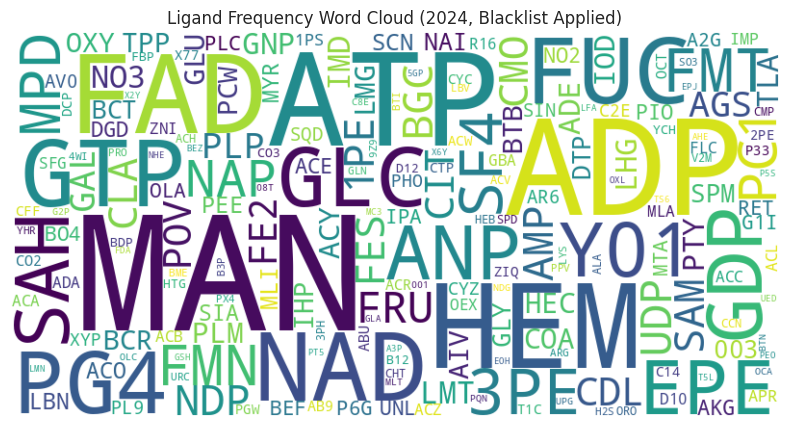

Top 20 Most Frequent Ligands (2024, Blacklist Applied):



,Ligand ID,Frequency
1,MAN,448
2,ADP,300
3,ATP,281
4,HEM,227
5,FAD,197
6,NAD,141
7,GTP,135
8,FUC,129
9,PG4,112
10,GLC,105


In [14]:
#@markdown here you will see a wordcloud that represents how many times each ligand appears
#@markdown You will also see a table with frequencies

from collections import Counter
import re
from wordcloud import WordCloud

ligand_blacklist = ["GOL", "PEG", "CL", "NA", "HOH", "SO4", "PO4", "EDO", "DMS", "TRS", "MES", "PGE", "ACT", "NAG", "BMA", "CLR"]

def process_ligands(results):
    ligand_counts = Counter()
    for entry in results:
        if 'interacting_ligands' in entry:
            ligands_string = entry['interacting_ligands']
            if ligands_string: #check if empty
              # Extract ligand IDs from the string
              ligand_ids = re.findall(r'([A-Z0-9]{3}) :', ligands_string)
              ligand_counts.update(ligand_ids)

    # Removing  ligands
    for ligand in list(ligand_counts):
        if ligand in ligand_blacklist:
            del ligand_counts[ligand]
    return ligand_counts

ligand_counts = process_ligands(results)
#print(ligand_counts.most_common(20)) this line is to check the ligands


wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ligand_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Ligand Frequency Word Cloud (2024, Blacklist Applied)")
plt.show()


top_n = 20  # Or however many you want to display
top_ligands = ligand_counts.most_common(top_n)

df_ligands = pd.DataFrame(top_ligands, columns=["Ligand ID", "Frequency"])
df_ligands.index = df_ligands.index + 1
print(f"Top {top_n} Most Frequent Ligands (2024, Blacklist Applied):\n")

display(df_ligands)

# NMR in 2024

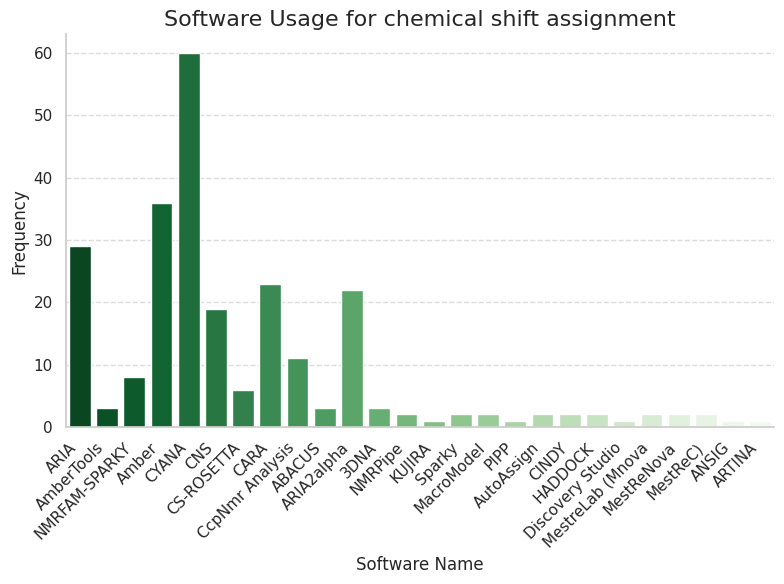

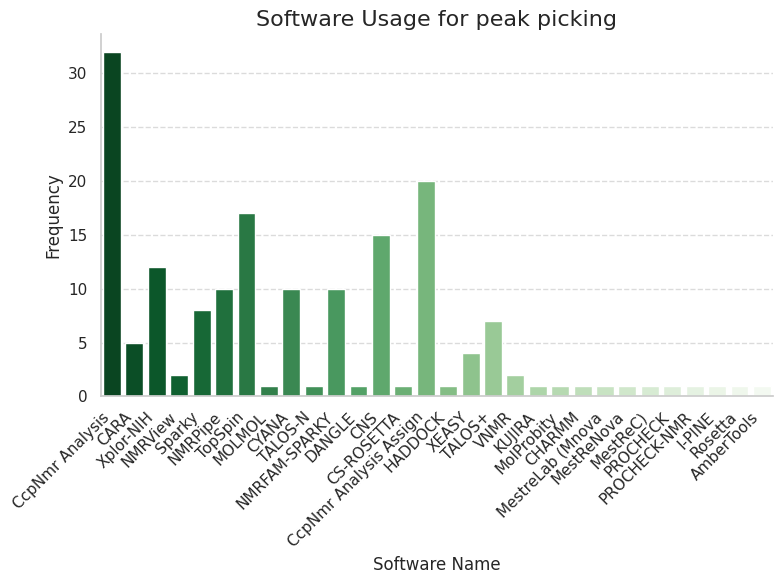

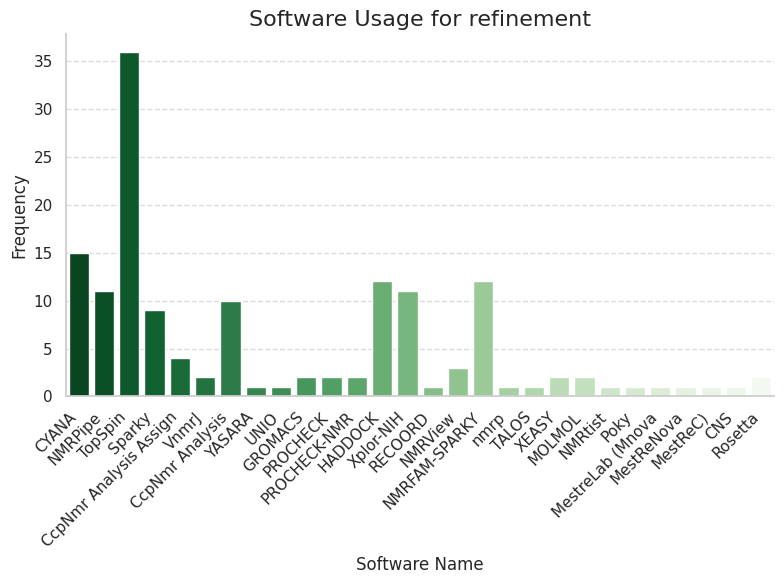

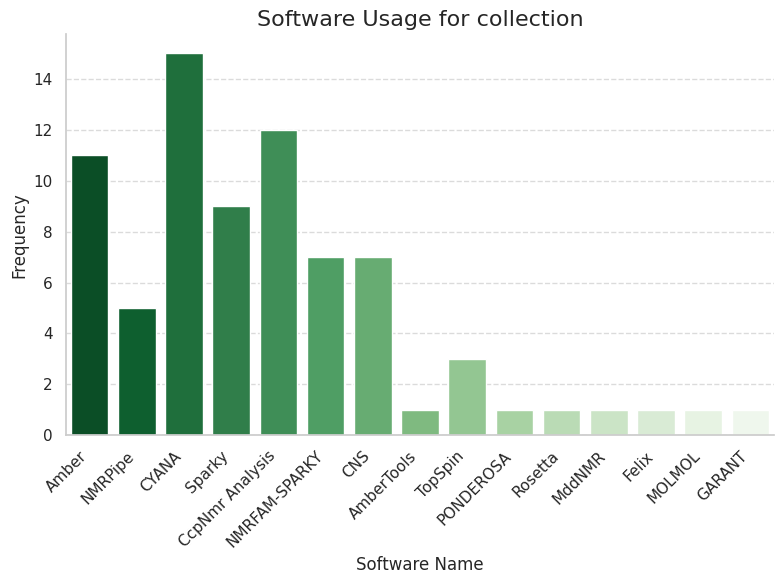

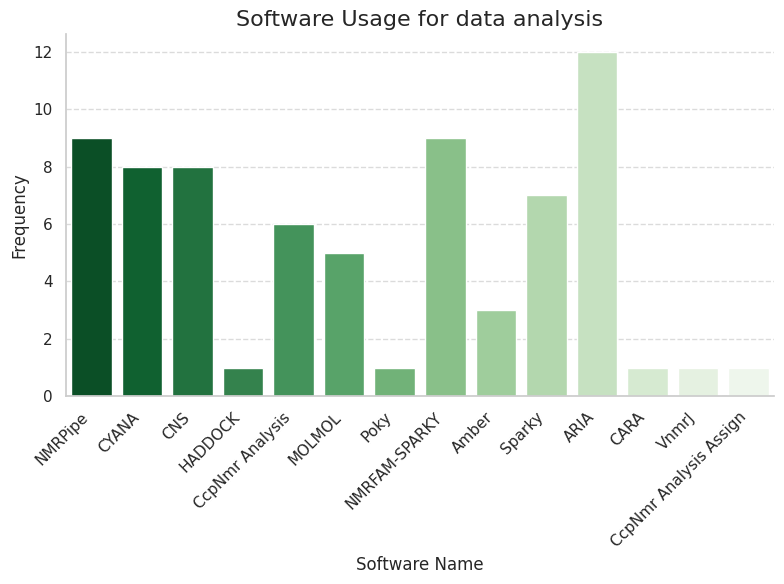

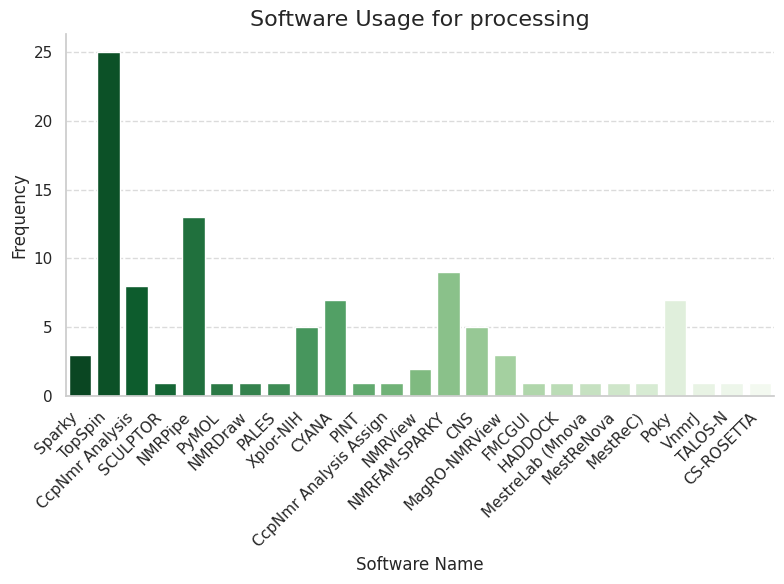

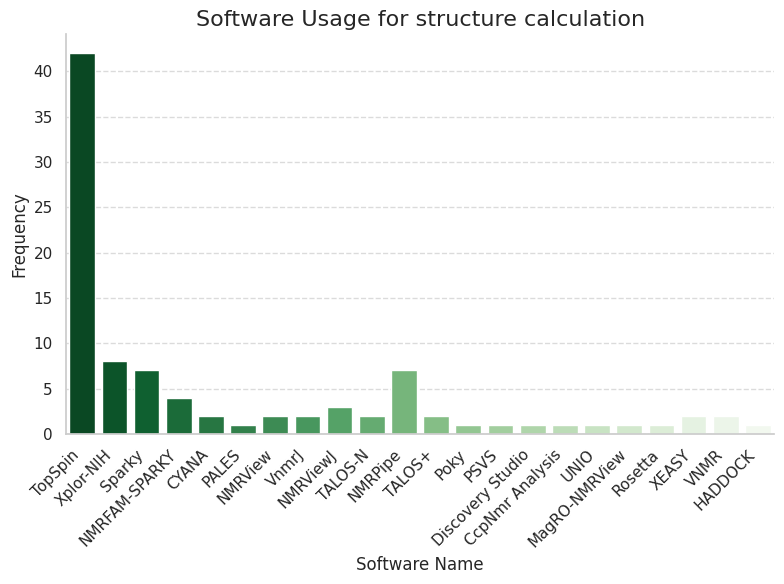

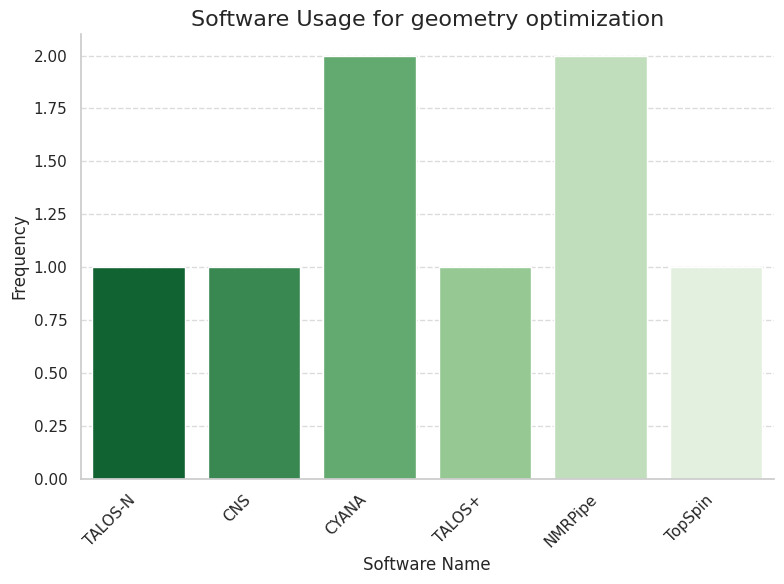

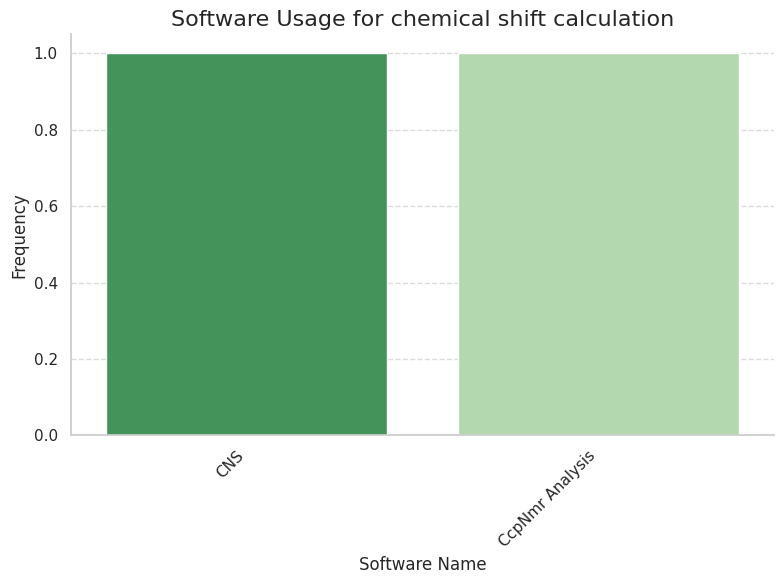

In [15]:
#@markdown run this to create a table just for NMR data
results_df = pd.DataFrame(results)
nmr_results = pd.DataFrame(results)[(results_df['experimental_method'] == "Solution NMR")].drop(columns=["em_electron_detection", "em_resolution"], axis=1)
nmr_results.reset_index(drop=True, inplace=True)
import altair as alt

def extract_and_count(df):
    """
    Extracts software classifications and names, counts occurrences,
    and returns the data for plotting.
    """
    software_counts = {}

    for _, row in df.iterrows():
        classifications = row['q_nmr_software_classification'].split(',')
        software_names = row['q_nmr_software_name'].split(',')

        for classification, software_name in zip(classifications, software_names):
            classification = classification.strip()
            software_name = software_name.strip()

            if classification not in software_counts:
                software_counts[classification] = {}
            for name in software_name.replace('/', ',').split(','):
                name = name.strip()
                if name:
                    if name not in software_counts[classification]:
                        software_counts[classification][name] = 0
                    software_counts[classification][name] += 1

    return software_counts

def plot_software_usage(software_counts):
    """
    Creates individual bar plots for each NMR Software Classification using seaborn with a 'Greens' palette.
    """
    for classification, counts in software_counts.items():
        df = pd.DataFrame({'Software': list(counts.keys()), 'Count': list(counts.values())})

        plt.figure(figsize=(8, 6))

        ax = sns.barplot(x='Software', y='Count', data=df, hue='Software', palette='Greens_r', legend=False)  # Assign 'Software' to 'hue'
        plt.xlabel('Software Name', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title(f'Software Usage for {classification}', fontsize=16)
        plt.xticks(rotation=45, ha="right")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        sns.despine()
        plt.tight_layout()
        plt.show()

software_counts = extract_and_count(nmr_results)
plot_software_usage(software_counts)


# X-ray in 2024

In [16]:
#@markdown Run this to create a table just for X-ray data

xray_results = pd.DataFrame(results)[(results_df['experimental_method'] == "X-ray diffraction")].drop(columns=["em_electron_detection", "em_resolution"], axis=1)
xray_results.reset_index(drop=True, inplace=True)
xray_results = xray_results.sort_values('resolution', ascending=True)
xray_results

display(xray_results)

,q_all_molecule_names,assembly_composition,entity_weight,experimental_method,journal,organism_scientific_name,pdb_id,processing_site,resolution,title,refinement_software,synchrotron_site,q_nmr_software_classification,q_nmr_software_name,interacting_ligands
7374,Crambin,protein structure,4728.410,X-ray diffraction,IUCrJ,Crambe hispanica subsp. abyssinica,9ewk,PDBE,0.70,Solvent organization in ultrahigh-resolution p...,SHELX,APS,NaN,NaN,EOH : ETHANOL
3749,DnaJ homolog subfamily B member 8,protein structure,671.699,X-ray diffraction,Structure,Homo sapiens,8dts,RCSB,0.75,X-ray crystal structure of AFSSFN from chapero...,PHENIX,APS,NaN,NaN,NaN
659,"1,4-beta-N-acetylmuramidase C,Allergen Gal d I...",protein structure,14331.160,X-ray diffraction,To be published,Gallus gallus,8rt2,PDBE,0.80,Hen Egg White Lysozyme Crystallized with Bioas...,PHENIX,ESRF,NaN,NaN,"CL : CHLORIDE ION,DO3 : 10-((2R)-2-HYDROXYPROP..."
4991,UIC-1-L6M,protein structure,1392.627,X-ray diffraction,Biomacromolecules,synthetic construct,8v5z,RCSB,0.84,UIC-1 mutant - UIC-1-L6M,PHENIX,APS,NaN,NaN,CCN : ACETONITRILE
342,"Beta-lactamase,Beta-lactamase CTX-M-15,Beta-la...",protein structure,28292.990,X-ray diffraction,To be published,Klebsiella pneumoniae,8r30,PDBE,0.85,Structure of CTX-M-15 complexed with benzoxabo...,PHENIX,Diamond,NaN,NaN,"CL : CHLORIDE ION,DMS : DIMETHYL SULFOXIDE,NA ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,DNA (5'-D(*CP*AP*GP*CP*AP*TP*CP*GP*CP*CP*TP*GP...,DNA/DNA complex,5445.545,X-ray diffraction,Proc Natl Acad Sci U S A,synthetic construct,8sjn,RCSB,7.30,[3T13] Self-assembling left-handed tensegrity ...,PHENIX,APS,NaN,NaN,NaN
1164,DNA (5'-D(P*CP*AP*TP*CP*TP*AP*GP*CP*TP*CP*GP*T...,DNA/DNA complex,6124.965,X-ray diffraction,Proc Natl Acad Sci U S A,synthetic construct,8sjw,RCSB,7.64,[4T28] Self-assembling right-handed tensegrity...,PHENIX,APS,NaN,NaN,NaN
2728,DNA (5'-D(*CP*AP*GP*CP*AP*TP*CP*GP*CP*CP*TP*GP...,DNA/DNA complex,5141.352,X-ray diffraction,Proc Natl Acad Sci U S A,synthetic construct,8sjm,RCSB,8.08,[3T12] Self-assembling left-handed tensegrity ...,PHENIX,APS,NaN,NaN,NaN
1807,DNA (5'-D(P*GP*AP*CP*AP*TP*CP*AP*CP*AP*GP*TP*G...,DNA/DNA complex,6465.213,X-ray diffraction,Proc Natl Acad Sci U S A,synthetic construct,8sjv,RCSB,8.59,[4T24] Self-assembling left-handed tensegrity ...,PHENIX,APS,NaN,NaN,NaN


In [17]:
#@markdown For 2024 releases, table of entries determined by X-ray diffraction binned by resolution cut-off.

def pandas_plot_binned(df, column_to_group_by, bin_cat, bin_range, graph_type='bar'):
    df[bin_cat] = pd.cut(df[column_to_group_by],bin_range)
    ds = df.groupby(bin_cat, observed=False)['pdb_id'].nunique()
    ds.index = ds.index.astype(str)
    ds.index = ds.index.str[1:-1]
    ds.index = ds.index.str.replace(', ', '-') + ' Å'
    return(ds)

bin_cat = 'X-ray resolution cut-off'
bin_range = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 10]
ds_xray_binned = pandas_plot_binned(xray_results, column_to_group_by='resolution', bin_cat=bin_cat, bin_range=bin_range)

# Convert pandas series object with one column (called 'pdb_id' to be renamed to 'no_of_entries')
counts = ds_xray_binned
counts.rename('no_of_entries', inplace=True)

# Make a pandas series object with one column (renamed to 'percentage')
counts_by_percent = (counts / counts.sum()) * 100
counts_by_percent = counts_by_percent.round(1)
counts_by_percent.rename('percentage', inplace=True)

# Merge both series into a DataFrame
df_xray_binned = pd.merge(counts, counts_by_percent, right_index=True, left_index=True)

display(df_xray_binned)

,no_of_entries,percentage
X-ray resolution cut-off,,
0.0-0.5 Å,0,0.0
0.5-1.0 Å,49,0.5
1.0-1.5 Å,1604,17.4
1.5-2.0 Å,3590,38.9
2.0-2.5 Å,2169,23.5
2.5-3.0 Å,1229,13.3
3.0-3.5 Å,434,4.7
3.5-4.0 Å,109,1.2
4.0-10.0 Å,38,0.4


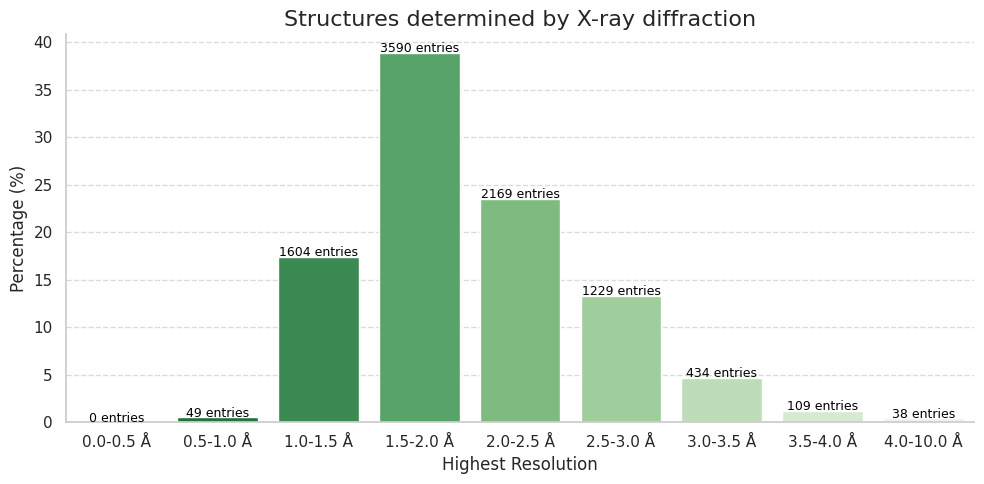

In [18]:
#@title Resolution for X-ray used in 2024

#@markdown This plot will show structures determined with X-ray binned based on high resolution resolution in 2024.

# Create a figure with a specified size
plt.figure(figsize=(10, 5))

# Create a bar plot with seaborn
# x: values of df_xray_binned['percentage']
# y: index of df_xray_binned
# hue: index of df_xray_binned (for color coding)
# palette: color palette for the bars
ax = sns.barplot(y=df_xray_binned['percentage'].to_numpy(), x=df_xray_binned.index, hue=df_xray_binned.index, palette='Greens_r')

# Set the title of the plot
plt.title("Structures determined by X-ray diffraction", fontsize=16)

# Set the x-axis label
plt.ylabel('Percentage (%)', fontsize=12)

# Set the y-axis label
plt.xlabel('Highest Resolution', fontsize=12)

# Annotate each bar with its percentage value and number of entries
# Change the range to iterate over the actual length of the DataFrame
for value in range(len(df_xray_binned)):
    entries = df_xray_binned['no_of_entries'].to_numpy()[value]
    percent_value = df_xray_binned['percentage'].round(1).to_numpy()[value]
    # Annotate the bar with the percentage value and number of entries
    ax.annotate(f'{entries} entries', (df_xray_binned.index[value], df_xray_binned['percentage'].to_numpy()[value]),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 3),
                textcoords='offset points')

# Remove the top and right spines from the plot for a cleaner look
sns.despine()

# Add a grid to the y-axis with dashed lines and some transparency
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the layout to make sure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [19]:
#@title Entries with the highest X-ray resolution this year
top_5_resolution = xray_results.sort_values('resolution').head(5)
top_5_resolution

,q_all_molecule_names,assembly_composition,entity_weight,experimental_method,journal,organism_scientific_name,pdb_id,processing_site,resolution,title,refinement_software,synchrotron_site,q_nmr_software_classification,q_nmr_software_name,interacting_ligands,X-ray resolution cut-off
7374,Crambin,protein structure,4728.410,X-ray diffraction,IUCrJ,Crambe hispanica subsp. abyssinica,9ewk,PDBE,0.70,Solvent organization in ultrahigh-resolution p...,SHELX,APS,NaN,NaN,EOH : ETHANOL,"(0.5, 1.0]"
3749,DnaJ homolog subfamily B member 8,protein structure,671.699,X-ray diffraction,Structure,Homo sapiens,8dts,RCSB,0.75,X-ray crystal structure of AFSSFN from chapero...,PHENIX,APS,NaN,NaN,NaN,"(0.5, 1.0]"
659,"1,4-beta-N-acetylmuramidase C,Allergen Gal d I...",protein structure,14331.160,X-ray diffraction,To be published,Gallus gallus,8rt2,PDBE,0.80,Hen Egg White Lysozyme Crystallized with Bioas...,PHENIX,ESRF,NaN,NaN,"CL : CHLORIDE ION,DO3 : 10-((2R)-2-HYDROXYPROP...","(0.5, 1.0]"
4991,UIC-1-L6M,protein structure,1392.627,X-ray diffraction,Biomacromolecules,synthetic construct,8v5z,RCSB,0.84,UIC-1 mutant - UIC-1-L6M,PHENIX,APS,NaN,NaN,CCN : ACETONITRILE,"(0.5, 1.0]"
342,"Beta-lactamase,Beta-lactamase CTX-M-15,Beta-la...",protein structure,28292.990,X-ray diffraction,To be published,Klebsiella pneumoniae,8r30,PDBE,0.85,Structure of CTX-M-15 complexed with benzoxabo...,PHENIX,Diamond,NaN,NaN,"CL : CHLORIDE ION,DMS : DIMETHYL SULFOXIDE,NA ...","(0.5, 1.0]"


# Cryo EM in 2024

In [20]:
#@title Cryo EM entries

#@markdown Run this to create a table just for cryo EM data

em_results = pd.DataFrame(results)[(results_df['experimental_method'] == "Electron Microscopy")].drop(columns=["resolution"], axis=1)
em_results.reset_index(drop=True, inplace=True)
em_results = em_results.sort_values('em_resolution', ascending=True)
em_results

,q_all_molecule_names,assembly_composition,em_electron_detection,em_resolution,entity_weight,experimental_method,journal,organism_scientific_name,pdb_id,processing_site,title,refinement_software,synchrotron_site,q_nmr_software_classification,q_nmr_software_name,interacting_ligands
1095,"Ferritin H subunit,Ferritin heavy chain,Ferrit...",protein structure,FEI FALCON IV (4k x 4k),1.09,20079.594,Electron Microscopy,Nat Commun,Mus musculus,8rqb,PDBE,Cryo-EM structure of mouse heavy-chain apoferr...,NaN,NaN,NaN,NaN,ZN : ZINC ION
383,"6,7-dimethyl-8-ribityllumazine synthase,DMRL s...",protein structure,FEI FALCON IV (4k x 4k),1.42,17769.350,Electron Microscopy,IUCrJ,Aquifex aeolicus,8yt4,PDBJ,Structure of Aquifex aeolicus Lumazine Synthas...,NaN,NaN,NaN,NaN,PO4 : PHOSPHATE ION
4235,"Ferritin H subunit,Ferritin heavy chain,Ferrit...",protein structure,GATAN K3 BIOQUANTUM (6k x 4k),1.51,21097.630,Electron Microscopy,To be published,Mus musculus,9iuy,PDBJ,Cryo-EM structure of mouse heavy-chain apoferr...,NaN,NaN,NaN,NaN,"K : POTASSIUM ION,MG : MAGNESIUM ION"
745,"CDK-activating kinase assembly factor MAT1,CDK...",protein/protein complex,TFS FALCON 4i (4k x 4k),1.7,10234.531,Electron Microscopy,Nat Commun,Homo sapiens,8p79,PDBE,Cryo-EM structure of CAK with averaged inhibit...,NaN,NaN,NaN,NaN,NaN
4607,"PSII D1 protein 1,Photosystem II Q(B) protein ...",protein/protein complex,FEI FALCON IV (4k x 4k),1.71,38265.625,Electron Microscopy,Science,Thermosynechococcus vestitus BP-1,9evx,PDBE,cryoEM structure of Photosystem II averaged ac...,NaN,NaN,NaN,NaN,"BCR : BETA-CAROTENE,BCT : BICARBONATE ION,CL :..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,"23 kDa protein,23K,62 kDa peptide,Core protein...",protein/protein complex,TFS FALCON 4i (4k x 4k),9.7,71073.480,Electron Microscopy,mBio,Vaccinia virus WR,8r5i,PDBE,In situ structure of the Vaccinia virus (WR) A...,NaN,NaN,NaN,NaN,NaN
4769,"Genome polyprotein,Polyprotein,Polyprotein (Fr...",protein/protein complex,FEI FALCON II (4k x 4k),9.8,53730.660,Electron Microscopy,To be published,Dengue virus 3,8jn6,PDBJ,Cryo-EM structure of the small tail club shape...,NaN,NaN,NaN,NaN,NaN
2592,"PNPase,Polynucleotide phosphorylase,Polyribonu...",RNA/protein complex,NaN,NaN,82117.984,Electron Microscopy,Arch Biochem Biophys,Mycobacterium tuberculosis,8wx0,PDBJ,PNPase of M.tuberculosis with its RNA substrate,NaN,NaN,NaN,NaN,NaN
2624,"PNPase,Polynucleotide phosphorylase,Polyribonu...",protein structure,NaN,NaN,82117.984,Electron Microscopy,Arch Biochem Biophys,Mycobacterium tuberculosis,8wxf,PDBJ,PNPase of Mycobacterium tuberculosis,NaN,NaN,NaN,NaN,NaN


In [21]:
#@title EM detector overview

#@markdown Generating the detector information

# Assuming 'results' is a DataFrame and 'pandas_count' is a function that groups and counts data

# Make a pandas series object with one column (called 'pdb_id' to be renamed to 'no_of_entries')
counts = pandas_count(results, column_to_group_by='em_electron_detection')
counts.rename('no_of_entries', inplace=True)

# Make a pandas series object with one column (renamed to 'percentage')
counts_by_percent = (counts / counts.sum()) * 100
counts_by_percent.rename('percentage', inplace=True)

# Merge both series into a DataFrame
df_detectors = pd.merge(counts, counts_by_percent, right_index=True, left_index=True)

# Get rows with partial matches
value1 = 'GATAN K3'
value2 = 'GATAN K2'
df_partial_match1 = df_detectors[df_detectors.index.str.contains(value1, case=False)]
df_partial_match2 = df_detectors[df_detectors.index.str.contains(value2, case=False)]

# Exclude rows with commas
df_filtered1 = df_partial_match1[~df_partial_match1.index.str.contains(',', na=False)]
df_filtered2 = df_partial_match2[~df_partial_match2.index.str.contains(',', na=False)]

list1 = df_filtered1.index.tolist()
list2 = df_filtered2.index.tolist()

# Create a dictionary with all values set to 'GATAN K3 (6k x 4k)'
keys = list1
index_mapping1 = {value: 'GATAN K3 (6k x 4k)' for value in keys}

# Create a dictionary with all values set to 'GATAN K2 (4k x 4k)'
keys = list2
index_mapping2 = {value: 'GATAN K2 (4k x 4k)' for value in keys}

# Rename the index values
df_detectors.rename(index=index_mapping1, inplace=True)
df_detectors.rename(index=index_mapping2, inplace=True)

# Combine rows with the same index values by summing them
df_detectors = df_detectors.groupby(df_detectors.index).sum()

# Sort the DataFrame rows by 'no_of_entries' in descending order
df_detectors = df_detectors.sort_values(by='no_of_entries', ascending=False)

# Round the values in the 'Score' column to 2 decimal places
df_detectors['Score'] = df_detectors['percentage'].round(2)

display(df_detectors)

,no_of_entries,percentage,Score
em_electron_detection,,,
GATAN K3 (6k x 4k),3940,68.013119,68.01
FEI FALCON IV (4k x 4k),759,13.102020,13.10
GATAN K2 (4k x 4k),662,11.427585,11.43
FEI FALCON III (4k x 4k),260,4.488175,4.49
TFS FALCON 4i (4k x 4k),96,1.657172,1.66
FEI FALCON II (4k x 4k),43,0.742275,0.74
FEI FALCON I (4k x 4k),5,0.086311,0.09
OTHER,4,0.069049,0.07
"GATAN K3 (6k x 4k),TFS FALCON 4i (4k x 4k)",3,0.051787,0.05


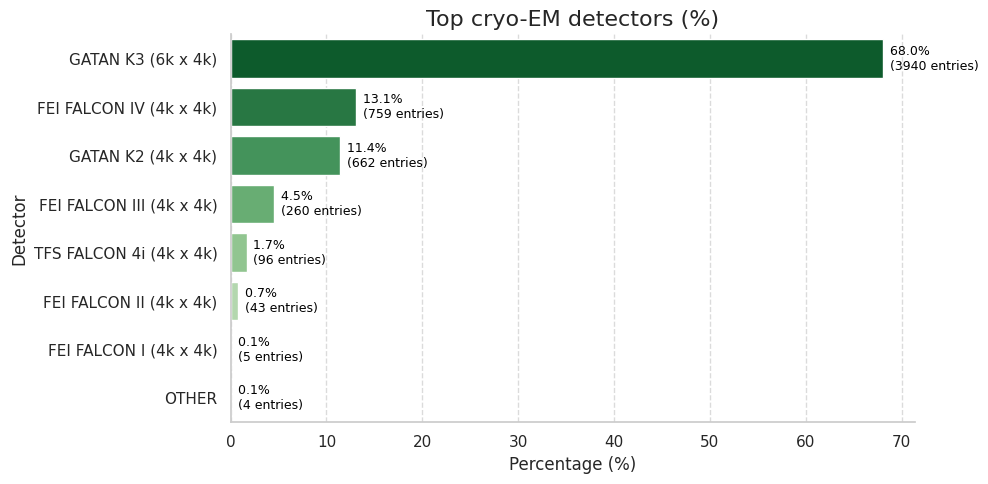

In [22]:
#@markdown This plot will show the detectors utilized for cryo EM data collection for entries released in 2024.

# Limit to top 10 entries
df_detectors = df_detectors.head(8)

# Create a figure with a specified size
plt.figure(figsize=(10, 5))

# Create a bar plot with seaborn
# x: values of df_detectors['percentage']
# y: index of df_detectors
# hue: index of df_detectors (for color coding)
# palette: color palette for the bars
ax = sns.barplot(x=df_detectors['percentage'].to_numpy(), y=df_detectors.index, hue=df_detectors.index, palette='Greens_r')

# Set the title of the plot
plt.title("Top cryo-EM detectors (%)", fontsize=16)

# Set the x-axis label
plt.xlabel('Percentage (%)', fontsize=12)

# Set the y-axis label
plt.ylabel('Detector', fontsize=12)

# Annotate each bar with its percentage value and number of entries
for value in range(0, 8):
    entries = df_detectors['no_of_entries'].to_numpy()[value]
    percent_value = df_detectors['percentage'].round(1).to_numpy()[value]
    # Annotate the bar with the percentage value and number of entries
    ax.annotate(f'{percent_value}% \n({entries} entries)', (df_detectors['percentage'].to_numpy()[value], df_detectors.index[value]),
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0),
                textcoords='offset points')

# Add a grid to the x-axis with dashed lines and some transparency
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove the top and right spines from the plot for a cleaner look
sns.despine()

# Adjust the layout to make sure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [23]:
#@markdown For 2024 releases, table of entries determined by cryo EM binned by resolution cut-off.

# Drop rows where column 'A' has missing values
em_results = em_results.dropna(subset=['em_resolution'])
em_results = em_results.astype({'em_resolution' : float})
em_results = em_results.sort_values('em_resolution', ascending=True)

bin_cat = 'cryo EM resolution cut-off'
bin_range = [0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 10, 30]
ds_em_binned = pandas_plot_binned(em_results, column_to_group_by='em_resolution', bin_cat=bin_cat, bin_range=bin_range)

# Convert pandas series object with one column (called 'pdb_id' to be renamed to 'no_of_entries')
counts = ds_em_binned
counts.rename('no_of_entries', inplace=True)

# Make a pandas series object with one column (renamed to 'percentage')
counts_by_percent = (counts / counts.sum()) * 100
counts_by_percent = counts_by_percent.round(1)
counts_by_percent.rename('percentage', inplace=True)

# Merge both series into a DataFrame
df_em_binned = pd.merge(counts, counts_by_percent, right_index=True, left_index=True)

display(df_em_binned)
counts = ds_em_binned
counts.rename('no_of_entries', inplace=True)

# Make a pandas series object with one column (renamed to 'percentage')
counts_by_percent = (counts / counts.sum()) * 100
counts_by_percent = counts_by_percent.round(1)
counts_by_percent.rename('percentage', inplace=True)

# Merge both series into a DataFrame
df_em_binned = pd.merge(counts, counts_by_percent, right_index=True, left_index=True)

display(em_results)

,no_of_entries,percentage
cryo EM resolution cut-off,,
0.0-1.0 Å,0,0.0
1.0-1.5 Å,2,0.0
1.5-2.0 Å,68,1.2
2.0-2.5 Å,447,7.7
2.5-3.0 Å,1645,28.4
3.0-3.5 Å,2101,36.3
3.5-4.0 Å,960,16.6
4.0-5.0 Å,329,5.7
5.0-10.0 Å,219,3.8


,q_all_molecule_names,assembly_composition,em_electron_detection,em_resolution,entity_weight,experimental_method,journal,organism_scientific_name,pdb_id,processing_site,title,refinement_software,synchrotron_site,q_nmr_software_classification,q_nmr_software_name,interacting_ligands,cryo EM resolution cut-off
1095,"Ferritin H subunit,Ferritin heavy chain,Ferrit...",protein structure,FEI FALCON IV (4k x 4k),1.09,20079.594,Electron Microscopy,Nat Commun,Mus musculus,8rqb,PDBE,Cryo-EM structure of mouse heavy-chain apoferr...,NaN,NaN,NaN,NaN,ZN : ZINC ION,"(1.0, 1.5]"
383,"6,7-dimethyl-8-ribityllumazine synthase,DMRL s...",protein structure,FEI FALCON IV (4k x 4k),1.42,17769.350,Electron Microscopy,IUCrJ,Aquifex aeolicus,8yt4,PDBJ,Structure of Aquifex aeolicus Lumazine Synthas...,NaN,NaN,NaN,NaN,PO4 : PHOSPHATE ION,"(1.0, 1.5]"
4235,"Ferritin H subunit,Ferritin heavy chain,Ferrit...",protein structure,GATAN K3 BIOQUANTUM (6k x 4k),1.51,21097.630,Electron Microscopy,To be published,Mus musculus,9iuy,PDBJ,Cryo-EM structure of mouse heavy-chain apoferr...,NaN,NaN,NaN,NaN,"K : POTASSIUM ION,MG : MAGNESIUM ION","(1.5, 2.0]"
745,"CDK-activating kinase assembly factor MAT1,CDK...",protein/protein complex,TFS FALCON 4i (4k x 4k),1.70,10234.531,Electron Microscopy,Nat Commun,Homo sapiens,8p79,PDBE,Cryo-EM structure of CAK with averaged inhibit...,NaN,NaN,NaN,NaN,NaN,"(1.5, 2.0]"
4607,"PSII D1 protein 1,Photosystem II Q(B) protein ...",protein/protein complex,FEI FALCON IV (4k x 4k),1.71,38265.625,Electron Microscopy,Science,Thermosynechococcus vestitus BP-1,9evx,PDBE,cryoEM structure of Photosystem II averaged ac...,NaN,NaN,NaN,NaN,"BCR : BETA-CAROTENE,BCT : BICARBONATE ION,CL :...","(1.5, 2.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4485,"Mitotic-spindle organizing protein 1,Mitotic-s...",protein/protein complex,GATAN K3 BIOQUANTUM (6k x 4k),17.00,7749.854,Electron Microscopy,EMBO J,Xenopus laevis,9eoj,PDBE,Vertebrate microtubule-capping gamma-tubulin r...,NaN,NaN,NaN,NaN,NaN,"(10.0, 30.0]"
556,"Nucleocapsid protein,Nucleoprotein,Protein N",protein structure,GATAN K3 (6k x 4k),18.00,50883.324,Electron Microscopy,Structure,Thogotovirus,8ryt,PDBE,Structural characterization of Thogoto Virus n...,NaN,NaN,NaN,NaN,NaN,"(10.0, 30.0]"
4586,"LOC397931 protein,Tubulin alpha chain",protein/protein complex,GATAN K3 BIOQUANTUM (6k x 4k),23.00,50120.297,Electron Microscopy,EMBO J,Xenopus laevis,9eok,PDBE,Minus end of the vertebrate gamma-tubulin ring...,NaN,NaN,NaN,NaN,"GDP : GUANOSINE-5'-DIPHOSPHATE,GTP : GUANOSINE...","(10.0, 30.0]"
319,"GBP-1,GTP-binding protein 1,Guanine nucleotide...",protein structure,GATAN K3 (6k x 4k),26.80,69267.930,Electron Microscopy,EMBO J,Homo sapiens,8r1a,PDBE,Model of the membrane-bound GBP1 oligomer,NaN,NaN,NaN,NaN,"AF3 : ALUMINUM FLUORIDE,GDP : GUANOSINE-5'-DIP...","(10.0, 30.0]"


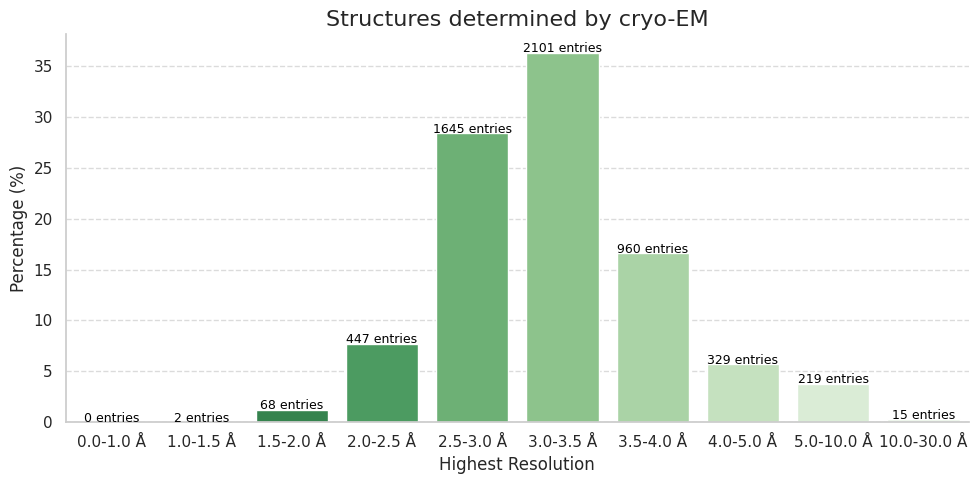

In [24]:
#@title Resolution for cryo-EM used in 2024

#@markdown This plot will show structures determined with cryo EM binned based on high resolution resolution in 2024.

# Create a figure with a specified size
plt.figure(figsize=(10, 5))

# Create a bar plot with seaborn
# x: values of df_em_binned['percentage']
# y: index of df_em_binned
# hue: index of df_em_binned (for color coding)
# palette: color palette for the bars
ax = sns.barplot(y=df_em_binned['percentage'].to_numpy(), x=df_em_binned.index, hue=df_em_binned.index, palette='Greens_r')

# Set the title of the plot
plt.title("Structures determined by cryo-EM", fontsize=16)

# Set the x-axis label
plt.ylabel('Percentage (%)', fontsize=12)

# Set the y-axis label
plt.xlabel('Highest Resolution', fontsize=12)

# Annotate each bar with its percentage value and number of entries
# Change the range to iterate over the actual length of the DataFrame
for value in range(len(df_em_binned)):
    entries = df_em_binned['no_of_entries'].to_numpy()[value]
    percent_value = df_em_binned['percentage'].round(1).to_numpy()[value]
    # Annotate the bar with the percentage value and number of entries
    ax.annotate(f'{entries} entries', (df_em_binned.index[value], df_em_binned['percentage'].to_numpy()[value]),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 3),
                textcoords='offset points')

# Remove the top and right spines from the plot for a cleaner look
sns.despine()

# Add a grid to the y-axis with dashed lines and some transparency
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the layout to make sure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [25]:
#@title Cryo EM entries with the highest resolution
top_5_resolution = em_results.sort_values('em_resolution').head(5)
top_5_resolution

,q_all_molecule_names,assembly_composition,em_electron_detection,em_resolution,entity_weight,experimental_method,journal,organism_scientific_name,pdb_id,processing_site,title,refinement_software,synchrotron_site,q_nmr_software_classification,q_nmr_software_name,interacting_ligands,cryo EM resolution cut-off
1095,"Ferritin H subunit,Ferritin heavy chain,Ferrit...",protein structure,FEI FALCON IV (4k x 4k),1.09,20079.594,Electron Microscopy,Nat Commun,Mus musculus,8rqb,PDBE,Cryo-EM structure of mouse heavy-chain apoferr...,NaN,NaN,NaN,NaN,ZN : ZINC ION,"(1.0, 1.5]"
383,"6,7-dimethyl-8-ribityllumazine synthase,DMRL s...",protein structure,FEI FALCON IV (4k x 4k),1.42,17769.350,Electron Microscopy,IUCrJ,Aquifex aeolicus,8yt4,PDBJ,Structure of Aquifex aeolicus Lumazine Synthas...,NaN,NaN,NaN,NaN,PO4 : PHOSPHATE ION,"(1.0, 1.5]"
4235,"Ferritin H subunit,Ferritin heavy chain,Ferrit...",protein structure,GATAN K3 BIOQUANTUM (6k x 4k),1.51,21097.630,Electron Microscopy,To be published,Mus musculus,9iuy,PDBJ,Cryo-EM structure of mouse heavy-chain apoferr...,NaN,NaN,NaN,NaN,"K : POTASSIUM ION,MG : MAGNESIUM ION","(1.5, 2.0]"
745,"CDK-activating kinase assembly factor MAT1,CDK...",protein/protein complex,TFS FALCON 4i (4k x 4k),1.70,10234.531,Electron Microscopy,Nat Commun,Homo sapiens,8p79,PDBE,Cryo-EM structure of CAK with averaged inhibit...,NaN,NaN,NaN,NaN,NaN,"(1.5, 2.0]"
4607,"PSII D1 protein 1,Photosystem II Q(B) protein ...",protein/protein complex,FEI FALCON IV (4k x 4k),1.71,38265.625,Electron Microscopy,Science,Thermosynechococcus vestitus BP-1,9evx,PDBE,cryoEM structure of Photosystem II averaged ac...,NaN,NaN,NaN,NaN,"BCR : BETA-CAROTENE,BCT : BICARBONATE ION,CL :...","(1.5, 2.0]"


In [26]:
#@title Comparing X-ray vs cryoEM
#@markdown This is an interctive plot using plotly
import plotly.express as px

# Ensure resolution is numeric and handle missing values
valid_xray_entries = xray_results[(xray_results['resolution'] != '')].copy()
valid_xray_entries['resolution'] = pd.to_numeric(valid_xray_entries['resolution'])

valid_em_entries = em_results[(em_results['em_resolution'] != '')].copy()
valid_em_entries['em_resolution'] = pd.to_numeric(valid_em_entries['em_resolution'])

# Create a new DataFrame with 'Resolution' and 'Method' columns
xray_data = pd.DataFrame({'Resolution': valid_xray_entries['resolution'], 'Method': 'X-ray'})
em_data = pd.DataFrame({'Resolution': valid_em_entries['em_resolution'], 'Method': 'Cryo-EM'})
combined_data = pd.concat([xray_data, em_data], ignore_index=True)

# Create Plotly histogram
fig = px.histogram(combined_data, x="Resolution", color="Method", barmode="overlay", title="Resolution distribution by experimental method (2024)")

# Customize x-axis labels, layout, and legend position
fig.update_layout(
    xaxis_title='Resolution (Å)',
    legend_title_text='Method',  # Set legend title
    legend=dict(x=0, y=-0.2, orientation="h", yanchor="top", xanchor="left"),  # Position legend at the bottom
    bargap=0.01 #adjust the gap between bars
)
fig.update_traces(opacity=0.7)

# Display the interactive plot
fig.show()
